In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from imu_dataset import IMUDataset
from model import IMUModelSmall
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
import tensorflow.keras.callbacks as cb

# Hyperparameters

In [7]:
VERSION = 'v1'
DATASET_PATH = "../model/dataset"
EXPORT_PATH = Path(f"model_{VERSION}")
TRAIN_VALID_SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 600
EVAL = "loss" # loss or acc

In [8]:
def show_sample(sample, label):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(IMUDataset.IDX_TO_CLASS[label], fontsize=16)
    axs[0].set_title("Accelerometer")
    axs[0].plot(sample[:, 0], label="x")
    axs[0].plot(sample[:, 1], label="y")
    axs[0].plot(sample[:, 2], label="z")
    axs[0].legend()
    axs[1].set_title("Gyroscope")
    axs[1].plot(sample[:, 3], label="x")
    axs[1].plot(sample[:, 4], label="y")
    axs[1].plot(sample[:, 5], label="z")
    axs[1].legend()
    plt.show()

# Data preprocessing

In [9]:
dataset = IMUDataset(base_path=DATASET_PATH)

idxs = list(range(len(dataset)))

# set a good seed or
# in alternative, shuffle data so that it is balanced between classes
random.seed(30)
tf.random.set_seed(30)

random.shuffle(idxs)

split = int(len(dataset) * TRAIN_VALID_SPLIT)

idxs_train = idxs[:split]
idxs_valid = idxs[split:]

# split dataset into train and validation
train_data = np.stack([dataset[i][0] for i in idxs_train])
train_labels = np.stack([dataset[i][1] for i in idxs_train])

valid_data = np.stack([dataset[i][0] for i in idxs_valid])
valid_labels = np.stack([dataset[i][1] for i in idxs_valid])

train_data.shape, train_labels.shape, valid_data.shape, valid_labels.shape

((195, 300, 6), (195,), (49, 300, 6), (49,))

In [10]:
from collections import defaultdict

train = defaultdict(lambda: 0)
valid = defaultdict(lambda: 0)

for i in idxs_train:
    _, label = dataset[i]

    train[label] += 1

for i in idxs_valid:
    _, label = dataset[i]

    valid[label] += 1    

print("Train")
for k, v in train.items():
    print(f"{IMUDataset.IDX_TO_CLASS[k]}: {v}")

print("\nValid")
for k, v in valid.items():
    print(f"{IMUDataset.IDX_TO_CLASS[k]}: {v}")

Train
forehand: 49
backhand: 50
nothing: 48
serve: 48

Valid
forehand: 12
nothing: 13
serve: 13
backhand: 11


# Model

In [11]:
model = IMUModelSmall(*dataset.compute_means_stds())
model.build(input_shape=(None, 300, 6))
model.summary()

Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "imu_model_small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalize (Normalize)       multiple                  0         
                                                                 
 average_pooling1d (AverageP  multiple                 0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 conv1d (Conv1D)             multiple                  76        
                                                                 
 max_pooling1d (MaxPooling1D  multiple                 0         
 )                                                               
                                   

In [12]:
earlyStopping = cb.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = cb.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Training

In [14]:
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=32,
                    validation_data=(valid_data, valid_labels))

Epoch 1/600


2023-05-08 22:18:56.491685: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 1s 43ms/step - loss: 1.7675 - accuracy: 0.2821 - val_loss: 1.2198 - val_accuracy: 0.4490
Epoch 2/600
7/7 [==============================] - 0s 11ms/step - loss: 1.1983 - accuracy: 0.4410 - val_loss: 1.0886 - val_accuracy: 0.6122
Epoch 3/600
7/7 [==============================] - 0s 10ms/step - loss: 1.0026 - accuracy: 0.5487 - val_loss: 0.9643 - val_accuracy: 0.6327
Epoch 4/600
7/7 [==============================] - 0s 9ms/step - loss: 0.8951 - accuracy: 0.6103 - val_loss: 0.8567 - val_accuracy: 0.6122
Epoch 5/600
7/7 [==============================] - 0s 9ms/step - loss: 0.7087 - accuracy: 0.6923 - val_loss: 0.7730 - val_accuracy: 0.6735
Epoch 6/600
7/7 [==============================] - 0s 9ms/step - loss: 0.6809 - accuracy: 0.7128 - val_loss: 0.7028 - val_accuracy: 0.6939
Epoch 7/600
7/7 [==============================] - 0s 9ms/step - loss: 0.5886 - accuracy: 0.7487 - val_loss: 0.6311 - val_accuracy: 0.7347
Epoch 8/600
7/7 [===================

In [15]:
loss, acc = model.evaluate(valid_data,  valid_labels, verbose=0)

print(f"Valid | Loss: {loss:.4f}, Acc: {acc*100:.1f}%")

Valid | Loss: 0.0077, Acc: 100.0%


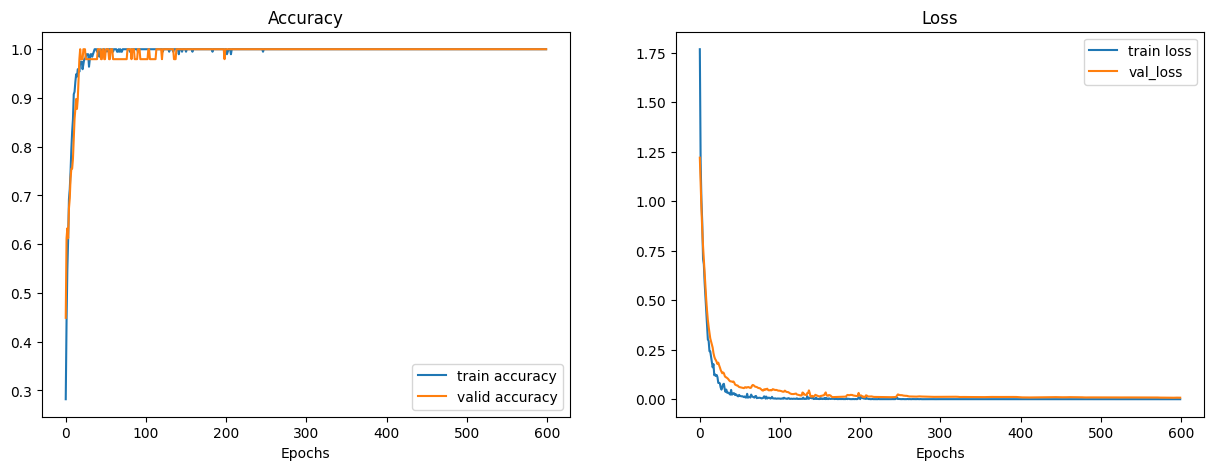

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(history.history['accuracy'], label='train accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'valid accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history.history['loss'], label='train loss')
axs[1].plot(history.history['val_loss'], label = 'val_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

plt.show()

# Test inference

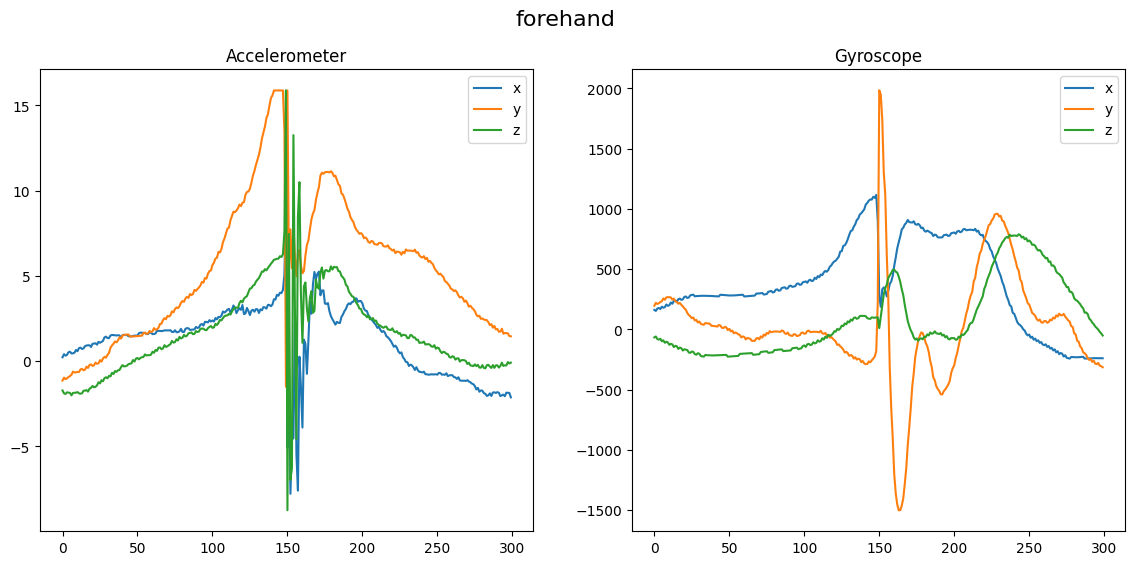

forehand: 100.00%
backhand: 0.00%
nothing: 0.00%
serve: 0.00%


In [17]:
data, label = dataset[15]
show_sample(data, label)

data = np.expand_dims(data, axis=0)

pred = model(data)
pred = pred.numpy() * 100
pred = pred[0].tolist()

for i, p in enumerate(pred):
    print(f"{IMUDataset.IDX_TO_CLASS[i]}: {p:.2f}%")

# Save model

In [18]:
tf.saved_model.save(model, EXPORT_PATH / f"model_{VERSION}")

INFO:tensorflow:Assets written to: model_v1/model_v1/assets


INFO:tensorflow:Assets written to: model_v1/model_v1/assets


# Quantization

In [19]:
def representative_dataset():
    for i in range(100):
        t = np.expand_dims(train_data[i], axis=0).astype(np.float32)
        yield [t]

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8

quantized_model = converter.convert()
print("Bytes", len(quantized_model))
(EXPORT_PATH / f"model_{VERSION}.tflite").write_bytes(quantized_model)

INFO:tensorflow:Assets written to: /var/folders/mk/xs0pl4dx2mv9kczxqtd16gk00000gn/T/tmpr1dxgxpx/assets


INFO:tensorflow:Assets written to: /var/folders/mk/xs0pl4dx2mv9kczxqtd16gk00000gn/T/tmpr1dxgxpx/assets


Bytes 13152


/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-08 22:19:36.275125: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-08 22:19:36.275138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


13152

# Evaluate quantized model

In [21]:
interpreter = tf.lite.Interpreter(model_content=quantized_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct = 0
total = 0
for i in range(len(valid_data)):

    # Prepare the input data
    input_data = valid_data[i:i+1]
    input_data = input_data.astype(np.float32)

    # Run the inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Compute the accuracy
    predicted_label = np.argmax(output_data)
    
    if predicted_label == valid_labels[i]:
        correct += 1
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy*100:.1f}%')

Accuracy: 100.0%


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Export to C array

In [32]:
!xxd -i {EXPORT_PATH}/model_{VERSION}.tflite > {EXPORT_PATH}/model_{VERSION}.h
!sed -i '' 's/model_v1_model_v1_tflite/model/g' {EXPORT_PATH}/model_{VERSION}.h